In [53]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [54]:
def findBoundingBoxFace(img):
    # using cv2 cascade classifier
    face_cascade = cv.CascadeClassifier()
    face_cascade.load(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    if(len(faces) == 0):
        return None
    bigFace = (0, 0, 0, 0)
    for i in range(len(faces)):
        if(faces[i][2]*faces[i][3] > bigFace[2]*bigFace[3]):
            bigFace = faces[i]
    (x, y, w, h) = bigFace
    return (x, y, w, h)    

In [55]:
def findBoundingBoxes(img):
    (x, y, w, h) = findBoundingBoxFace(img)
    if(x == None):
        return None
    (xb, yb, wb, hb) = (x-w, y-h, 3*w, img.shape[0] - y +h)
    return (xb, yb, wb, hb), (x, y, w, h)

In [56]:
def grabCut(img1, img2, rect1, rectb1, rect2, rectb2):
    (x1, y1, w1, h1) = rect1
    (xb1, yb1, wb1, hb1) = rectb1
    (x2, y2, w2, h2) = rect2
    (xb2, yb2, wb2, hb2) = rectb2

    front = img1.copy()
    back = img2.copy()

    if(w2*h2 > w1*h1):
        front = img2.copy()
        back = img1.copy()
        (txb1, tyb1, twb1, thb2), (tx1, ty1, tw1, th1) = (xb2, yb2, wb2, hb2), (x2, y2, w2, h2)
        (txb2, tyb2, twb2, thb2), (tx2, ty2, tw2, th2) = (xb1, yb1, wb1, hb1), (x1, y1, w1, h1)
        (xb1, yb1, wb1, hb1), (x1, y1, w1, h1) = (txb1, tyb1, twb1, thb2), (tx1, ty1, tw1, th1)

    # create mask
    mask = np.zeros(front.shape[:2], np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (xb1, yb1, wb1, hb1)
    cv.grabCut(front,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    cropped = front*mask2[:,:,np.newaxis]

    return mask2, back, front, cropped
        

In [57]:
def erodeWithEllipse(cropped):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    eroded = cv.erode(cropped, kernel, iterations=1)
    return eroded

In [58]:
img1 = cv.imread('./../data/inputs/backman.png')
img2 = cv.imread('./../data/inputs/frontman.png')

# interchange r and b channels
man = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
man2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

# find bounding boxes
face, body = findBoundingBoxes(man)
face2, body2= findBoundingBoxes(man2)


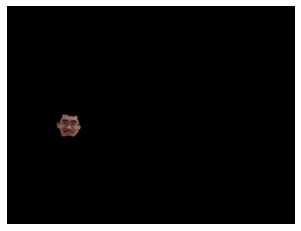

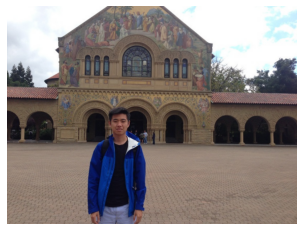

In [59]:
mask, back, front, cropped = grabCut(man, man2, face, body, face2, body2)
cropped = erodeWithEllipse(cropped)
face, body = findBoundingBoxes(cropped)

temp_cropped = cropped.copy()
temp_cropped[cropped<0]=0
plt.figure()
plt.axis("off")
plt.imshow(temp_cropped)
plt.show()

plt.figure()
plt.axis("off")
plt.imshow(back)
plt.show()